In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, RandomSampler
import matplotlib.pyplot as plt
import time
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from mnist_classifier.model import Mnist_classifer





In [2]:
batch = 64
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)


mnist_indice = torch.randperm(len(mnist))
mnist_train_sampler = RandomSampler(mnist_indice[:int(len(mnist) * 0.95)])
mnist_valid_sampler = RandomSampler(mnist_indice[int(len(mnist) * 0.95):])


mnist_train_dataloader = DataLoader(mnist, sampler=mnist_train_sampler, batch_size=batch)
mnist_val_dataloader = DataLoader(mnist, sampler=mnist_valid_sampler, batch_size=batch)

# for x, y in mnist_train_dataloader:
#     print(x[1])
#     print(y[1])
#     break
# for x, y in mnist_val_dataloader:
#     print(x[1])
#     print(y[1])
#     break

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

    

        self.output = nn.Sequential(nn.Linear(100, 256),#雜訊是長度512的tensor
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(256, 512),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(512, 784),
                                    nn.Tanh())#輸出值域要藉於-1~1
        
        self.output.apply(self.init_net_work)
    def forward(self, batch_size : int, use_gpu = False):
        x = torch.randn(batch_size * 100)#隨機正態分布
        x = x.view(-1, 100)
        if (use_gpu): x = x.to(device="cuda", dtype=torch.float32)
        return self.output(x)
    def generate_image(self, num : int):
        image = self.forward(batch_size=num)
        image = image.view(-1, 28, 28).detach().numpy()
        image = (image + 1) * 255 / 2
        return image
    
    def init_net_work(self, tensor : torch.tensor): 
        if (type(tensor) == nn.Linear):
            nn.init.kaiming_uniform_(tensor.weight, nonlinearity='leaky_relu')
            nn.init.zeros_(tensor.bias)

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.output = nn.Sequential(nn.Linear(784, 512),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 256),
                                    nn.LeakyReLU(0.2),
                                    nn.Dropout(0.3),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid()
                                    )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.output(x)

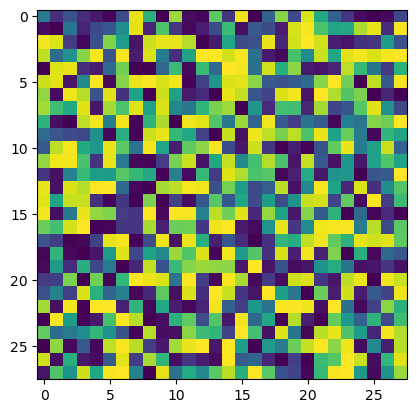

<All keys matched successfully>

In [5]:
#呼叫模型
generator = Generator()
classifier = Classifier()
image = generator.generate_image(10)
plt.imshow(image[0])
plt.show()

#使用手寫辨識模型
mnist_classifer = Mnist_classifer()
mnist_classifer_checkpoint = torch.load("mnist_classifier/checkpoint.pth")
mnist_classifer.load_state_dict(mnist_classifer_checkpoint)



In [6]:
#test classifier

def validate(classifier, loss_function, dataloader, use_gpu : bool):
    val_loss = 0
    count = 0
    classifier.eval()
    with torch.no_grad():
        for x, y in dataloader:
            count += 1
            label = torch.ones(len(x))
            if (use_gpu):
                x = x.to(device="cuda", dtype=torch.float32)
                label = label.to(device="cuda", dtype=torch.float32)

            predict = classifier(x)
            label = label.view(predict.shape)
            loss = loss_function(predict, label)
            val_loss += loss

    return val_loss / count


In [7]:
use_gpu = torch.cuda.is_available()

epoch = 1000
lr = 0.0002
beta = (0.5, 0.999)

optim_G = optim.Adam(generator.parameters(), lr=lr, betas=beta)#刪掉正規化
optim_C = optim.Adam(classifier.parameters(), lr=lr, betas=beta)
loss_function = nn.BCELoss()




if (use_gpu):
    print("GPU")
    loss_function = loss_function.to(device="cuda", dtype=torch.float32)
    generator = generator.to(device="cuda", dtype=torch.float32)
    classifier = classifier.to(device="cuda", dtype=torch.float32)
    

GPU


In [8]:
def classifer_loss_function(real : torch.tensor, fake : torch.tensor, ones_label : torch.tensor, zeros_label : torch.tensor):
    real_loss = loss_function(real, ones_label)#越大越好
    fake_loss = loss_function(fake, zeros_label)#越小越好
    return real_loss + fake_loss

def generator_loss_function(fake : torch.tensor, ones_label : torch.tensor):
    return loss_function(fake, ones_label)#越大越好

In [9]:
def train_c(x : torch.tensor) -> float:
    """
    x : train data

    return:
    classifier_loss
    """
    classifier.train()
    optim_C.zero_grad()
    optim_G.zero_grad()


    #根據batch大小生成對應大小標籤
    zeros_label = torch.zeros((len(x), 1))
    ones_label = torch.ones((len(x), 1))


    if (use_gpu): 
        x = x.to(device="cuda", dtype=torch.float32)
        zeros_label = zeros_label.to(device="cuda", dtype=torch.float32)
        ones_label = ones_label.to(device="cuda", dtype=torch.float32)

    #訓練辨識器
    classifier.train()
    #reshape mnist data
    x = x.view(-1, 784)     
    #生成假資料
    with torch.no_grad(): fake_mnist = generator(batch_size=len(x), use_gpu=use_gpu)

    #預測真假資料的分數
    real_predict = classifier(x)
    fake_predict = classifier(fake_mnist)

    #classifier_loss計算+反向傳播
    c_loss = classifer_loss_function(real_predict, fake_predict, ones_label, zeros_label)
    c_loss.backward()
    optim_C.step()
    
    return c_loss.item()


In [10]:
def train_g(x_size : int) -> float:
    """
    x_size : len(x)

    return : g_loss.item()
    """

    ones_label = torch.ones((x_size, 1))
    if (use_gpu): ones_label = ones_label.to(device="cuda", dtype=torch.float32)

    #訓練生成器
    optim_C.zero_grad()
    optim_G.zero_grad()
    classifier.eval()
    #生成假資料
    fake_mnist = generator(batch_size=x_size, use_gpu=use_gpu)

    #預測假資料的分數
    fake_predict = classifier(fake_mnist)

    #fake_loss計算+反向傳播
    g_loss = generator_loss_function(fake_predict, ones_label)
    g_loss.backward()
    optim_G.step()

    return g_loss.item()

epoch: 1/1000:
classifier train loss: 1.020590302585619, val loss: 0.39978915452957153 |  generator loss: 1.3145574038946535
save model


C:\Users\weiso131\AppData\Local\Temp\ipykernel_19644\2888401379.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  topk, top_class = mnist_classifer(torch.tensor(fake_images)).topk(1, dim=1)


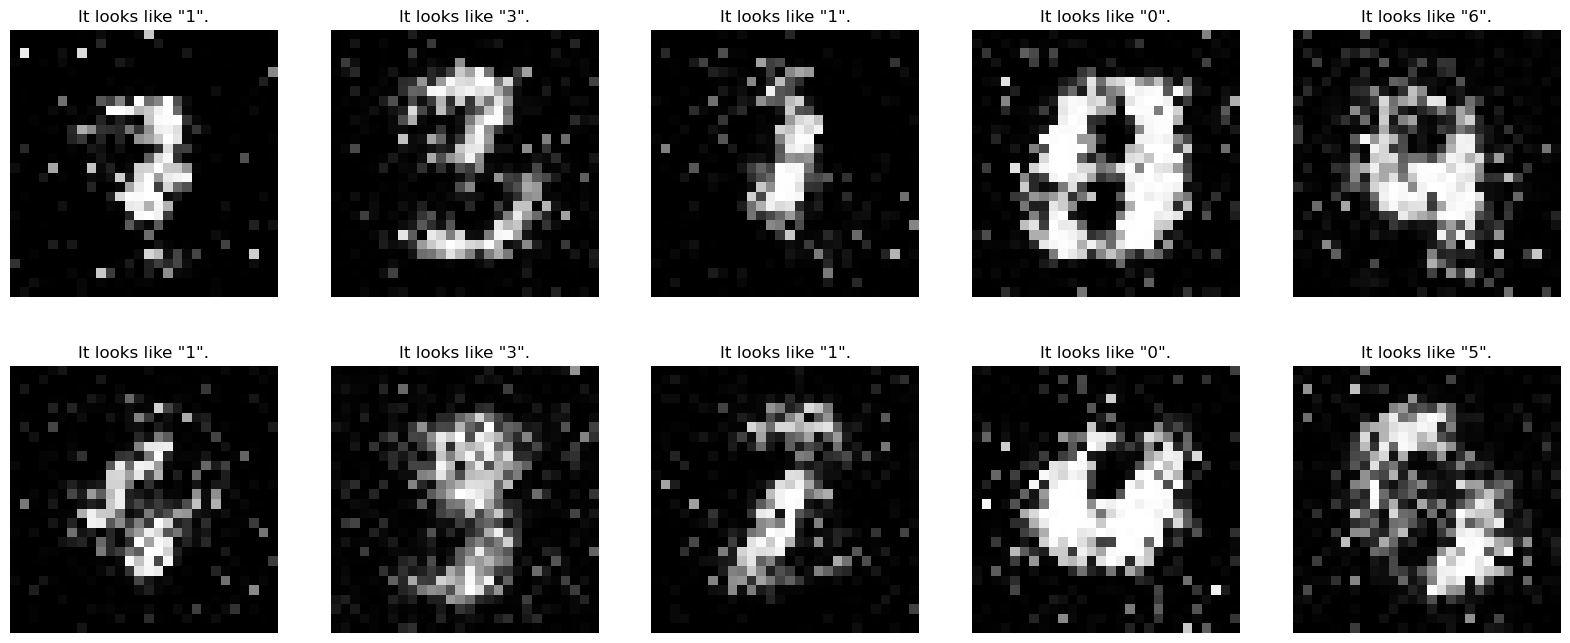

epoch: 2/1000:
classifier train loss: 1.1077313892769092, val loss: 0.5261772274971008 |  generator loss: 1.1350514541571388
epoch: 3/1000:
classifier train loss: 1.0813981855223342, val loss: 0.4022407829761505 |  generator loss: 1.1532414931172608
epoch: 4/1000:
classifier train loss: 1.0839000253297397, val loss: 0.38220861554145813 |  generator loss: 1.157812195260383
save model
epoch: 5/1000:
classifier train loss: 1.1142161429664235, val loss: 0.7008337378501892 |  generator loss: 1.1182438354567112
epoch: 6/1000:
classifier train loss: 1.1485999064012007, val loss: 0.5009833574295044 |  generator loss: 1.0720055277901466
epoch: 7/1000:
classifier train loss: 1.1750864342406944, val loss: 0.579425036907196 |  generator loss: 1.0373770528034998
epoch: 8/1000:
classifier train loss: 1.1868872965626445, val loss: 0.4368344843387604 |  generator loss: 1.0255269333971069
epoch: 9/1000:
classifier train loss: 1.2001569475790468, val loss: 0.6299708485603333 |  generator loss: 1.0208867

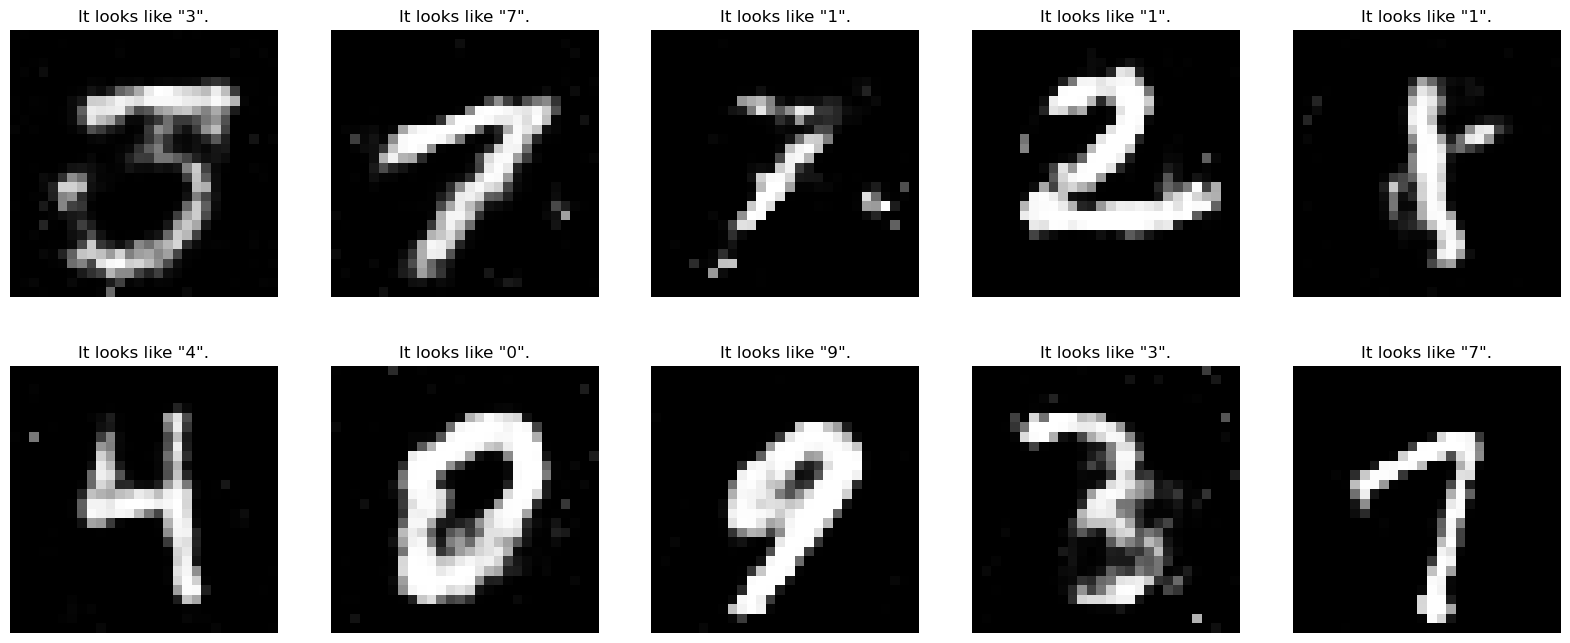

epoch: 102/1000:
classifier train loss: 1.2724631161802145, val loss: 0.6513514518737793 |  generator loss: 0.9996484706698845
epoch: 103/1000:
classifier train loss: 1.2710377510415451, val loss: 0.7671570181846619 |  generator loss: 0.996661678709165
epoch: 104/1000:
classifier train loss: 1.2737357133432938, val loss: 0.760760486125946 |  generator loss: 0.9938956328514048
epoch: 105/1000:
classifier train loss: 1.2707308774310198, val loss: 0.7666987776756287 |  generator loss: 0.9963548263047814
epoch: 106/1000:
classifier train loss: 1.2726931561257033, val loss: 0.7845264077186584 |  generator loss: 0.9942907328423694
epoch: 107/1000:
classifier train loss: 1.2725144928419496, val loss: 0.6383538842201233 |  generator loss: 0.9934757974011328
epoch: 108/1000:
classifier train loss: 1.2731581416595665, val loss: 0.7243489027023315 |  generator loss: 0.9992511181451389
epoch: 109/1000:
classifier train loss: 1.273250355463638, val loss: 0.7526348829269409 |  generator loss: 0.9966

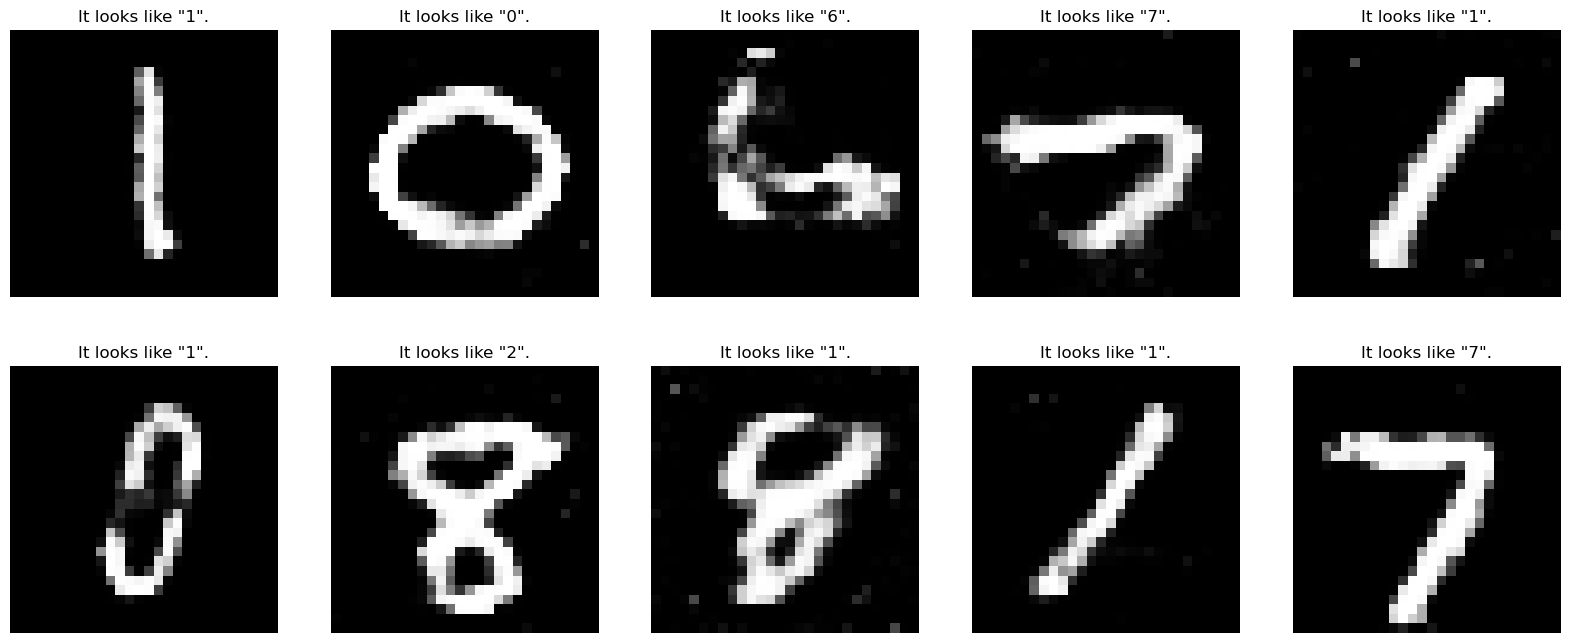

epoch: 202/1000:
classifier train loss: 1.2466975141454626, val loss: 0.6562403440475464 |  generator loss: 1.040699933782036
epoch: 203/1000:
classifier train loss: 1.2496108587342079, val loss: 0.6728769540786743 |  generator loss: 1.0322882569866416
epoch: 204/1000:
classifier train loss: 1.2469971945256362, val loss: 0.7074848413467407 |  generator loss: 1.0400618042474912
epoch: 205/1000:
classifier train loss: 1.24279630652448, val loss: 0.7427480816841125 |  generator loss: 1.0396172313310215
epoch: 206/1000:
classifier train loss: 1.2480385933660898, val loss: 0.7688546180725098 |  generator loss: 1.0400668879015544
epoch: 207/1000:
classifier train loss: 1.2468257979244228, val loss: 0.708198606967926 |  generator loss: 1.0395550808119853
epoch: 208/1000:
classifier train loss: 1.2440318269226553, val loss: 0.705893874168396 |  generator loss: 1.0403474016087892
epoch: 209/1000:
classifier train loss: 1.2462146560484846, val loss: 0.885698676109314 |  generator loss: 1.0374976

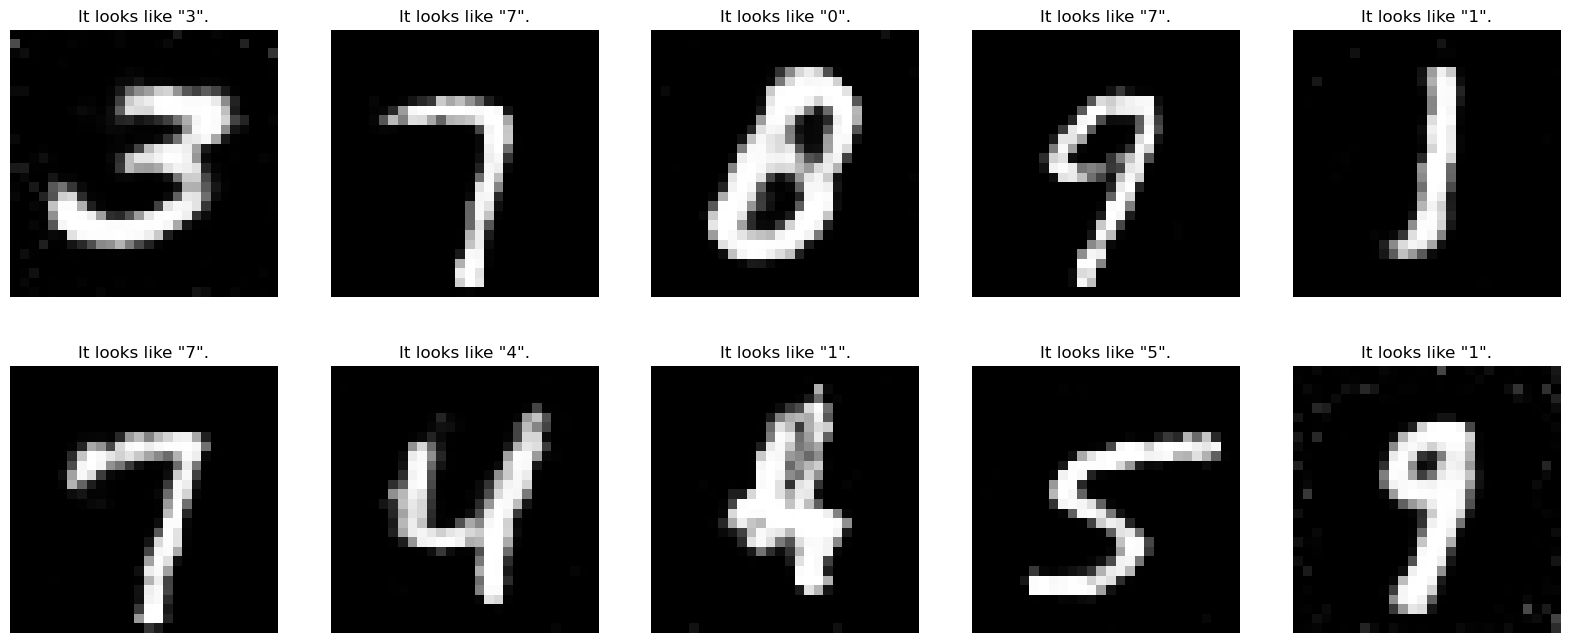

epoch: 302/1000:


KeyboardInterrupt: 

In [11]:
# classifier_loss = [1]
# generator_loss = [0]

min_val_loss = 1e9
max_val_acc = 0



mnist_classifer.eval()
for i in range(epoch):
    print(f"epoch: {i + 1}/{epoch}:")
    
    classifier_loss_epoch = 0
    generator_loss_epoch = 0
    
    
    count = 0
    
    for x, y in mnist_train_dataloader:
        
        count += 1

        classifier_loss_epoch += train_c(x)
        generator_loss_epoch += train_g(len(x))


    
    val_loss = validate(classifier, loss_function, mnist_val_dataloader, use_gpu)

    print(f"classifier train loss: {classifier_loss_epoch / count}, val loss: {val_loss} |  generator loss: {generator_loss_epoch / count}")
    

    #把最好的辨識器保存
    if (val_loss < min_val_loss):
        min_val_loss = val_loss
        checkpoint = classifier.state_dict()
        torch.save(checkpoint, "classifier_checkpoint.pth")
        print("save model")
    #辨識器壞了，拿最好的重新開始
    elif (abs(val_loss - min_val_loss) > 1):
        checkpoints = torch.load("classifier_checkpoint.pth")
        classifier.load_state_dict(checkpoint)
        print("redo model")
    

    torch.cuda.empty_cache()

    if (i % 100 == 0):
        if (use_gpu): generator = generator.to(device="cpu", dtype=torch.float32)
        fake_images = generator.generate_image(num=10).squeeze()
        fake_images = torch.tensor(fake_images)
        topk, top_class = mnist_classifer(torch.tensor(fake_images)).topk(1, dim=1)

        fig, axs = plt.subplots(2, 5, figsize=(20, 8))  # 創建一個2x5的子圖網路
        
        for i, ax in enumerate(axs.flat):
            
            ax.imshow(fake_images[i], cmap='gray')  # 顯示圖片
            ax.set_title(f"It looks like \"{int(top_class[i])}\".")
            ax.axis('off')  # 關閉坐標軸
           

        plt.show()
        if (use_gpu): generator = generator.to(device="cuda", dtype=torch.float32)
